In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from utils import niceprint, nicesubplots, without_diag, bfs_layout

In [2]:
np.random.seed(1)

In [3]:
def make_dag(layers):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    num_nodes_prev = 0
    for i, layer_size in enumerate(layers):
        if i == 0:
            for b in range(layer_size):
                g.add_edge(0, 1+b)
        else:
            prev_layer_size = layers[i - 1]
            for a in range(prev_layer_size):
                for b in range(layer_size):
                    g.add_edge(num_nodes_prev+a, num_nodes+b)
        num_nodes_prev = num_nodes
        num_nodes += layer_size
    g.graph["root"] = 0
    return g

In [4]:
def make_tree(branching_factors):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    nodes_prev_layer = [0]
    for i, factor in enumerate(branching_factors):
        nodes_current_layer = []
        for n in nodes_prev_layer:
            for c in range(factor):
                g.add_edge(n, num_nodes)
                nodes_current_layer.append(num_nodes)
                num_nodes += 1
        nodes_prev_layer = nodes_current_layer
    g.graph["root"] = 0
    return g

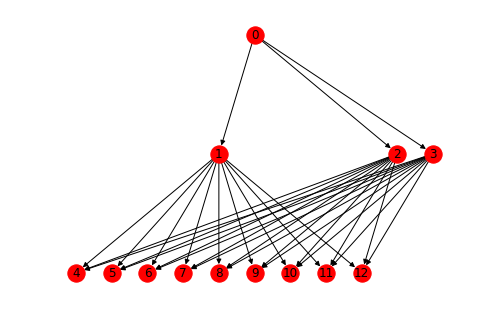

In [5]:
dense_dag = make_dag([3, 9])
nx.draw(dense_dag, pos=bfs_layout(dense_dag), with_labels=True)

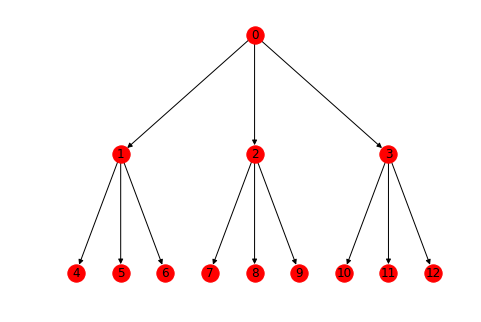

In [6]:
tree = make_tree([3, 3])
nx.draw(tree, pos=bfs_layout(tree), with_labels=True)

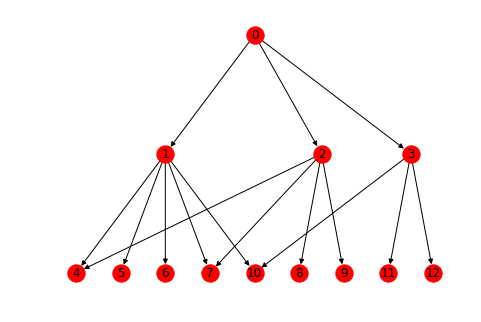

In [7]:
sparse_dag = make_tree([3, 3])
sparse_dag.add_edge(1, 7)
sparse_dag.add_edge(1, 10)
sparse_dag.add_edge(2, 4)
nx.draw(sparse_dag, pos=bfs_layout(sparse_dag), with_labels=True)

In [8]:
graphs = [("Tree", tree), ("DenseDAG", dense_dag), ("SparseDAG", sparse_dag)]

In [9]:
def niceimshow(X, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, **kwargs)
    ax.axis('off')

## Direct computation

Trying to compute pairwise probabilities directly

In [10]:
def get_alpha(num_children, pexit = None, scale = 1.0):
    if pexit is None:
        pexit = 1.0 / (num_children + 1)
    pother = (1 - pexit) / float(num_children)
    result = pother * np.ones(num_children + 1)
    result[0] = pexit
    result *= scale * (num_children + 1)
    return result

In [11]:
alpha = get_alpha(4, pexit = 1/2)
print(alpha)
print(alpha[0] / sum(alpha))

[2.5   0.625 0.625 0.625 0.625]
0.5


In [12]:
from collections import defaultdict, Counter
from functools import partial
import itertools

In [13]:
def gen_all_paths(g, prefix=None):
    if prefix is None:
        prefix = (g.graph["root"],)
    yield prefix
    for c in g.neighbors(prefix[-1]):
        new_prefix = prefix + (c,)
        for p in gen_all_paths(g, new_prefix):
            yield p

In [14]:
def compute_combo_probability(g, path_combo, alpha_func):
    # hPAM2 calculations
    def num_children(node):
        return len(list(g.neighbors(node)))
    def gen_transitions(r):
        assert len(r) > 0
        for i in range(len(r) - 1):
            yield (r[i], r[i + 1])
        if num_children(r[-1]) > 0:
            # Include any non-trivial ending transitions (ie, exiting the DAG before reaching a sink node)
            yield (r[-1], None)
    transitions = defaultdict(Counter)

    for path in path_combo:
        for src, dest in gen_transitions(path):
            transitions[src][dest] += 1
    
    result = 1.0
    for src, dest_counter in transitions.items():
        nc = num_children(src)
        alpha = alpha_func(nc)
        alpha_exit, alpha_child = alpha[0], alpha[1]
        denom = 1.0
        for i in range(sum(dest_counter.values())):
            denom *= alpha.sum() + i
        numer = 1.0
        for dest, count in dest_counter.items():
            a = alpha_exit if dest is None else alpha_child
            for i in range(count):
                numer *= a + i
        result *= numer / denom

    return result

In [15]:
def compute_combo_tensor(g, combo_size, alpha_func = None):
    if alpha_func is None:
        alpha_func = get_alpha
    num_nodes = len(g.nodes())
    result = np.zeros(tuple(num_nodes for i in range(combo_size)))
    for combo in itertools.product(gen_all_paths(g), repeat = combo_size):
        coords = tuple(c[-1] for c in combo)
        result[coords] += compute_combo_probability(g, combo, alpha_func)
    return result

In [16]:
def tensor_to_matrix(T):
    if np.ndim(T) < 2:
        T = np.atleast_2d(T)
    while np.ndim(T) > 2:
        if np.ndim(T) == 3:
            axis = 0 if T.shape[0] * T.shape[1] < T.shape[1] * T.shape[2] else 1
        else:
            axis = np.argmin(T.shape)
        T = np.concatenate(T, axis=axis)
    return T

In [17]:
R = compute_combo_tensor(tree, 3)
R.shape, R.sum()

((13, 13, 13), 1.0)

In [18]:
tensor_to_matrix(R).shape

(13, 169)

In [19]:
R = compute_combo_tensor(tree, 2, alpha_func=partial(get_alpha, pexit=None, scale=1))

In [20]:
R.sum()

1.0000000000000002

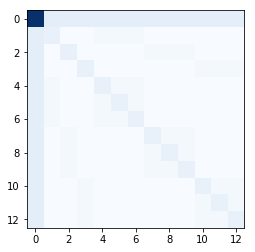

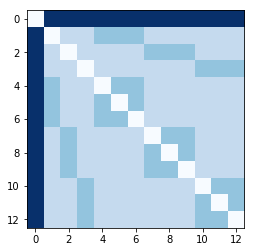

In [21]:
fig, ax = plt.subplots(); ax.imshow(             R , cmap='Blues');
fig, ax = plt.subplots(); ax.imshow(without_diag(R), cmap='Blues');

## Interactive experiments

In [22]:
import ipywidgets

In [23]:
from collections import OrderedDict

In [24]:
pexit_widget = ipywidgets.FloatSlider(0.5, min=0, max=1, step=0.05)
pexit_widget.layout.display = 'none'

auto_pexit_widget = ipywidgets.Checkbox(True, description="Auto-assign pexit")
def _observe_checkbox(change):
    pexit_widget.layout.display = 'none' if change['new'] else 'flex'
auto_pexit_widget.observe(_observe_checkbox, names='value')

@ipywidgets.interact_manual(
    select_graph = OrderedDict(graphs),
    combo_size = ipywidgets.Dropdown(value = 2, options = [1,2,3]),
    include_diag = [False, True],
    use_conditional = [False, True],
    alpha_scale = ipywidgets.FloatLogSlider(1, min=-2, max=1, step=0.1),
    auto_pexit = auto_pexit_widget,
    pexit = pexit_widget,
)
def _view_results(select_graph, combo_size, include_diag, use_conditional, alpha_scale, auto_pexit, pexit):
    global R, R_plot
    if auto_pexit:
        pexit = None
    R = compute_combo_tensor(select_graph, combo_size, alpha_func=partial(get_alpha, pexit=pexit, scale=alpha_scale))
    if use_conditional:
        R /= R.sum(axis=0)
    R_plot = R if include_diag else without_diag(R)
    R_plot = tensor_to_matrix(R_plot)
    fig, ax = plt.subplots(figsize=(20,4))
    ax.imshow(R_plot, cmap='Blues')
    ax.axis('off')
    ax.set_title("HPAM2")

interactive(children=(Dropdown(description='select_graph', options=OrderedDict([('Tree', <networkx.classes.dig…

Notes:
* Setting `pexit = 0` exactly corresponds to PAM above
* Setting `pexit = 0.423` **approximates** HPAM1 above
* Auto-assigning `pexit` exactly corresponds to HPAM2 above
  * For the Tree case, this corresponds exactly to `pexit = 0.25`
  * For the DAG case, this corresponds approximately to `pexit = 0.178`

The value 0.423 is an approximate minimizer of $\Vert(1/3, 1/3, 1/3) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that HPAM2 can get to a uniform probability distribution over depths, which is used in the HPAM1 tests above.

The value 0.178 is an approximate minimizer of $\Vert(1/4, 3/40, 27/40) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that a uniform value of `pexit` can get to a depth distribution of $(1/4, 3/40, 27/40)$ -- which is the exact depth distribution that we get from running HPAM2 on the fully-connected DAG and auto-assigning `pexit` on a per-node basis.

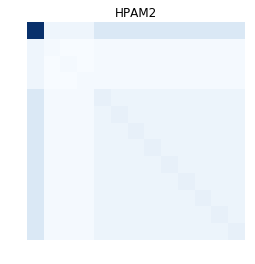

In [25]:
_view_results(
    select_graph=dense_dag,
    combo_size=2,
    include_diag=True,
    use_conditional=False,
    alpha_scale=1.0,
    auto_pexit=True,
    pexit=None,
)

In [26]:
depths = [0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
prob_by_depth = np.zeros(np.max(depths) + 1)
np.add.at(prob_by_depth, depths, R.sum(axis=0))
prob_by_depth

array([0.25 , 0.075, 0.675])

In [27]:
np.array([1/4, 3/40, 27/40])

array([0.25 , 0.075, 0.675])

In [28]:
from scipy.optimize import minimize_scalar

In [29]:
f = lambda x: np.array([x, x*(1-x), (1-x)**2])

In [30]:
target = np.array([1/3, 1/3, 1/3])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.33333333 0.33333333 0.33333333]
x = 0.4226497317237661 yields f(x) = [0.42264973 0.24401694 0.33333333]


In [31]:
target = np.array([1/4, 3/40, 27/40])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.25  0.075 0.675]
x = 0.17841616540420124 yields f(x) = [0.17841617 0.14658384 0.675     ]


## Tree Extraction

In [32]:
from tree_extraction import GreedyNoStructure, GreedyWithStructure, GreedyThreshold

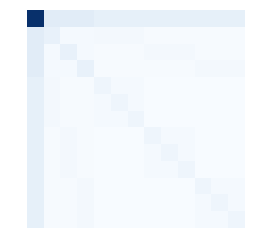

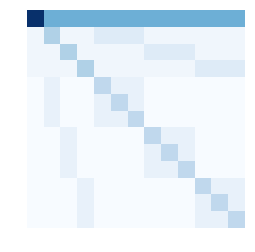

In [33]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
niceimshow(R, cmap='Blues');
niceimshow(R / R.sum(axis=0), cmap='Blues')

In [34]:
diagnostics = []
t1 = GreedyNoStructure.extract(R, apply_cond = True, diagnostics = diagnostics)

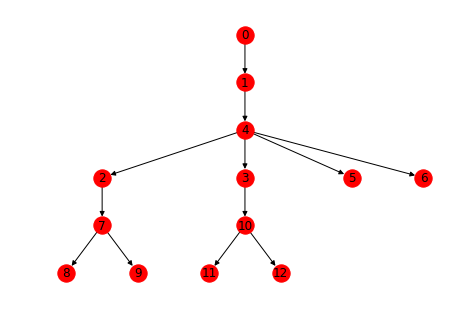

In [35]:
nx.draw(t1, pos=bfs_layout(t1), with_labels=True)

Select Root: 0
Add Edge: 0 --> 1
Add Edge: 1 --> 4
Add Edge: 4 --> 5
Add Edge: 4 --> 6
Add Edge: 4 --> 2
Add Edge: 2 --> 7
Add Edge: 7 --> 8
Add Edge: 7 --> 9
Add Edge: 4 --> 3
Add Edge: 3 --> 10
Add Edge: 10 --> 11
Add Edge: 10 --> 12


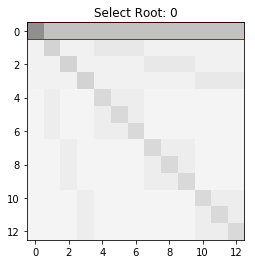

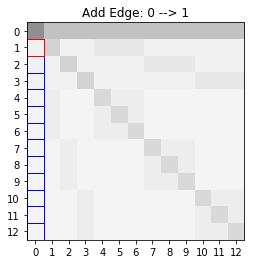

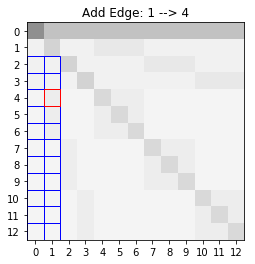

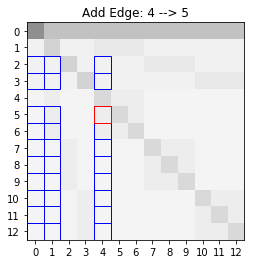

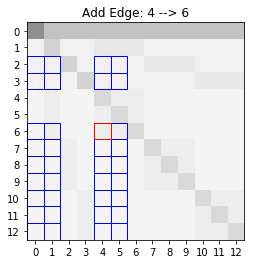

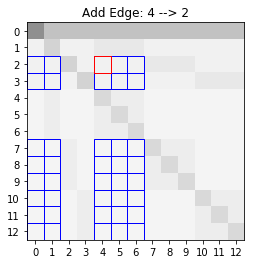

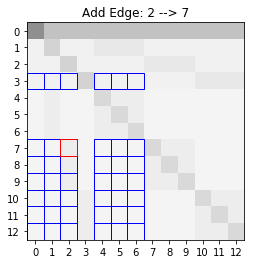

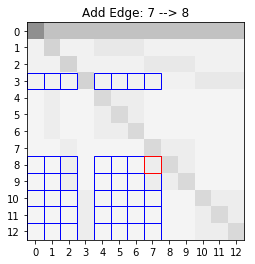

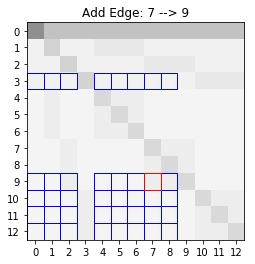

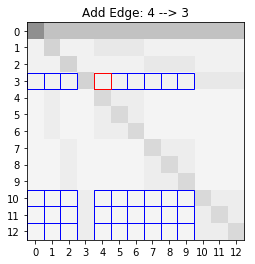

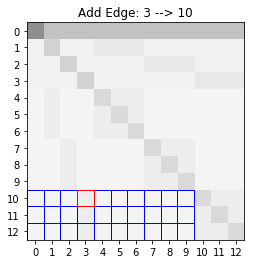

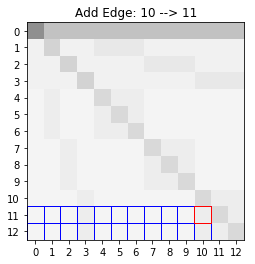

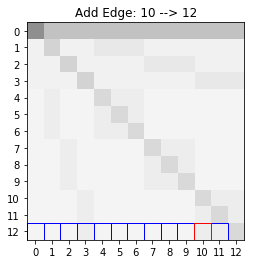

In [36]:
GreedyNoStructure.display_diagnostics(diagnostics)

In [37]:
t2 = GreedyWithStructure.extract(R, branching_factors=[3,3])

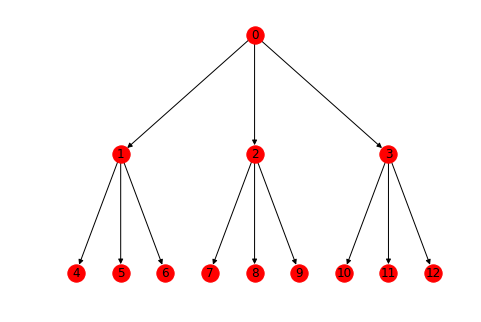

In [38]:
nx.draw(t2, pos=bfs_layout(t2), with_labels=True)

In [39]:
t3 = GreedyThreshold.extract(R, threshold = 0.1, apply_cond = True)

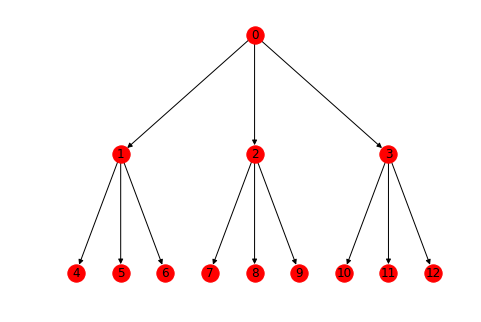

In [40]:
nx.draw(t3, pos=bfs_layout(t3), with_labels=True)

In [41]:
expected = {
    0: set([1,2,3]),
    1: set([4,5,6]),
    2: set([7,8,9]),
    3: set([10,11,12]),
}

In [42]:
def graph_diff(g, expected):
    result = {}
    all_nodes = set(g.nodes())
    for node in all_nodes:
        children_seen = set(g.neighbors(node))
        children_expected = set(expected.get(node, set()))
        if children_seen != children_expected:
            result[node] = {
                "actual": children_seen,
                "expected": children_expected,
            }
    for node in expected:
        if node not in all_nodes:
            result[node] = {
                "actual": set(),
                "expected": expected[node],
            }
    return result

In [43]:
graph_diff(tree, expected)

{}

In [44]:
graph_diff(t1, expected)

{0: {'actual': {1}, 'expected': {1, 2, 3}},
 1: {'actual': {4}, 'expected': {4, 5, 6}},
 2: {'actual': {7}, 'expected': {7, 8, 9}},
 3: {'actual': {10}, 'expected': {10, 11, 12}},
 4: {'actual': {2, 3, 5, 6}, 'expected': set()},
 7: {'actual': {8, 9}, 'expected': set()},
 10: {'actual': {11, 12}, 'expected': set()}}

In [45]:
graph_diff(t2, expected)

{}

In [46]:
graph_diff(t3, expected)

{}

[[0.0420 -0.0042 -0.0042 -0.0042 -0.0033 -0.0033 -0.0033 -0.0033 -0.0033 -0.0033 -0.0033 -0.0033 -0.0033]
 [-0.0042 0.0070 -0.0010 -0.0010 0.0012 0.0012 0.0012 -0.0008 -0.0008 -0.0008 -0.0008 -0.0008 -0.0008]
 [-0.0042 -0.0010 0.0070 -0.0010 -0.0008 -0.0008 -0.0008 0.0012 0.0012 0.0012 -0.0008 -0.0008 -0.0008]
 [-0.0042 -0.0010 -0.0010 0.0070 -0.0008 -0.0008 -0.0008 -0.0008 -0.0008 -0.0008 0.0012 0.0012 0.0012]
 [-0.0033 0.0012 -0.0008 -0.0008 0.0052 0.0010 0.0010 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006]
 [-0.0033 0.0012 -0.0008 -0.0008 0.0010 0.0052 0.0010 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006]
 [-0.0033 0.0012 -0.0008 -0.0008 0.0010 0.0010 0.0052 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006 -0.0006]
 [-0.0033 -0.0008 0.0012 -0.0008 -0.0006 -0.0006 -0.0006 0.0052 0.0010 0.0010 -0.0006 -0.0006 -0.0006]
 [-0.0033 -0.0008 0.0012 -0.0008 -0.0006 -0.0006 -0.0006 0.0010 0.0052 0.0010 -0.0006 -0.0006 -0.0006]
 [-0.0033 -0.0008 0.0012 -0.0008 -0.0006 -0.0006 -0.0006 0.0010 0.0010

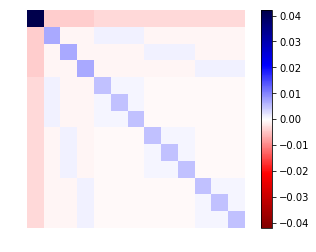

In [47]:
# Convert co-occurrence --> covariance
p_node = R.sum(axis=0, keepdims=True)
C = R - p_node.T.dot(p_node)
vmax = np.max(np.abs(C))
niceimshow(C, cmap='seismic_r', vmin=-vmax, vmax=vmax)
plt.colorbar(plt.gca().images[0]);
niceprint(C)

## Permutations of nodes

Here's a problem: if we swap some children & grandchildren for certain $R$ matrices, we get exactly the same matrix

In [48]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.25, scale=1.0))

In [49]:
def permute_square(X, perm):
    perm = np.reshape(perm, (-1, 1))
    return X[perm, perm.T]

In [50]:
# Swap some children & grandchildren
R2 = permute_square(R, [0,
                        4, 9, 11,
                        1, 5, 6,
                        7, 8, 2,
                        3, 10, 12])

In [51]:
niceprint(R - R2)
np.allclose(R, R2)

[[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.

True

## Unique values in $R$ matrix

Examine the pattern of unique values appearing in $R$

In [52]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.25, scale=1.0))

In [53]:
unique_vals = np.unique(R.flatten())
unique_vals

array([0.003125, 0.005   , 0.01    , 0.0125  , 0.1     ])

In [54]:
R_unique_indices = np.vectorize(lambda x: np.where(x == unique_vals)[0])(R)
niceprint(R_unique_indices)

[[4 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 2 0 0 1 1 1 0 0 0 0 0 0]
 [3 0 2 0 0 0 0 1 1 1 0 0 0]
 [3 0 0 2 0 0 0 0 0 0 1 1 1]
 [3 1 0 0 2 1 1 0 0 0 0 0 0]
 [3 1 0 0 1 2 1 0 0 0 0 0 0]
 [3 1 0 0 1 1 2 0 0 0 0 0 0]
 [3 0 1 0 0 0 0 2 1 1 0 0 0]
 [3 0 1 0 0 0 0 1 2 1 0 0 0]
 [3 0 1 0 0 0 0 1 1 2 0 0 0]
 [3 0 0 1 0 0 0 0 0 0 2 1 1]
 [3 0 0 1 0 0 0 0 0 0 1 2 1]
 [3 0 0 1 0 0 0 0 0 0 1 1 2]]


In [55]:
paths = {k: v[1:] for k, v in nx.algorithms.shortest_path(tree, source = 0).items()}
paths

{0: [],
 1: [1],
 2: [2],
 3: [3],
 4: [1, 4],
 5: [1, 5],
 6: [1, 6],
 7: [2, 7],
 8: [2, 8],
 9: [2, 9],
 10: [3, 10],
 11: [3, 11],
 12: [3, 12]}

In [56]:
diff_types = defaultdict(set)
for k1, v1 in paths.items():
    for k2, v2 in paths.items():
        c = d1 = d2 = 0
        for i in range(max(len(v1), len(v2))):
            found_diff = False
            if i >= len(v1):
                found_diff = True
                d2 += 1
            elif i >= len(v2):
                found_diff = True
                d2 += 1  # Note: d2 may correspond to v1 or v2, whichever is longer
                # ALT: d1 corresponds to v1: d1 += 1
            elif found_diff or v1[i] != v2[i]:
                found_diff = True
                d1 += 1
                d2 += 1
            else:
                c += 1
        if d1 == 0 and d2 == 0:
            dt = 'self'
        elif d1 == 0 and d2 == 1:
            dt = 'parent'
        elif d1 == 0 and d2 == 2:
            dt = 'grandparent'
        elif d1 == 1 and d2 == 1:
            dt = 'sibling'
        elif d1 == 1 and d2 == 2:
            dt = 'aunt'
        elif d1 == 2 and d2 == 2:
            dt = 'cousin'
        else:
            dt = 'other'
        dt += "({},{},{})".format(c, d1, d2)
        diff_types[dt].add(R[k1, k2])

vals_to_difftypes = defaultdict(set)
for k in diff_types:
    newval = np.asarray(sorted(list(diff_types[k])))
    diff_types[k] = newval
    if len(newval) > 1:
        print("Warning: more than 1 value for difftype {}: {}".format(k, newval))
    for v in newval:
        vals_to_difftypes[v].add(k)

for k in vals_to_difftypes:
    newval = sorted(list(vals_to_difftypes[k]))
    vals_to_difftypes[k] = newval
    if len(newval) > 1:
        print("Note: value {} appears in more than one difftype: {}".format(k, newval))

Note: value 0.0125 appears in more than one difftype: ['grandparent(0,0,2)', 'parent(0,0,1)']
Note: value 0.010000000000000002 appears in more than one difftype: ['self(1,0,0)', 'self(2,0,0)']
Note: value 0.003125 appears in more than one difftype: ['aunt(0,1,2)', 'cousin(0,2,2)', 'sibling(0,1,1)']
Note: value 0.005000000000000001 appears in more than one difftype: ['parent(1,0,1)', 'sibling(1,1,1)']


In [57]:
for i, v in enumerate(unique_vals):
    print("({}) {:.4f}: {}".format(i, v, ', '.join(vals_to_difftypes[v])))

(0) 0.0031: aunt(0,1,2), cousin(0,2,2), sibling(0,1,1)
(1) 0.0050: parent(1,0,1), sibling(1,1,1)
(2) 0.0100: self(1,0,0), self(2,0,0)
(3) 0.0125: grandparent(0,0,2), parent(0,0,1)
(4) 0.1000: self(0,0,0)


In [58]:
R.sum(axis=0)

array([0.25  , 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625])